## Imports 

Dataset: https://www.kaggle.com/datasets/shivamb/netflix-shows

In [1]:
import pandas as pd 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# imports - plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from IPython.display import HTML

from plotly.offline import iplot
import plotly as py
import cufflinks as cf

py.offline.init_notebook_mode(connected=True)
cf.go_offline()

***
## Load and preparing dataset

In [3]:
df = pd.read_csv('netflix_titles.csv')
# df.head(3)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


We can see we need to modify a few things:
 * First we will need to change date_added columns in to time objects for analysis. ( there is no need to change release_year since it is only the year and python can identify and sort it correctly ).
 * Second, we would like to see the cast and liset_in in different rows for better analysis of the cast actors - we will do it later.

In [4]:
df1 = df.copy()

In [5]:
df1['date_added'] = pd.to_datetime(df1['date_added'])
# df1.head()

### Check for nulls 

In [6]:
# df1.info()
df1.isna().sum()
# # for our analysis of countries we will need to remove null values since we can not modify it.
years = df1.dropna(subset=['country'])

## EDA for release year

In [7]:
# we will create here a simple function to do the following:
# create a groupby analysis for country and type
# createt timeline which is build from dual axis and sepreated

In [8]:
def plot_year(variable_count):
    grouped = years.groupby(['release_year', variable_count]).agg({'title': 'count'}).reset_index().rename(
        columns={'title': 'count'})
#     print(grouped)
    fig = px.line(data_frame=grouped, x='release_year', y = 'count',color=variable_count)
    fig.update_layout(#hovermode = 'x unified',
        height = 300, title = f'plot of {variable_count}', showlegend=False)
    fig.add_annotation(
        x='2010'
        , y=178+1
        , text=f'In 2010 begin a peak <br> in creation movies.'
        , yanchor='bottom'
        , showarrow=True
        , arrowhead=1
        , arrowsize=1
        , arrowwidth=2
        , arrowcolor="#636363"
        , ax=-20
        , ay=-30
        , font=dict(size=11, color="purple", family="Courier New, monospace")
        , align="left"
    )
    # fig.show() -> to display the full interactive plot
    fig.show("png") # -> to display the plot in github 

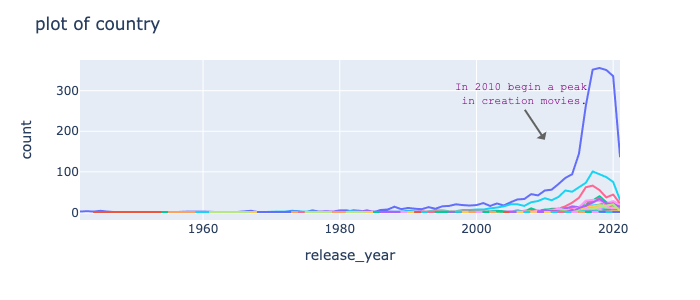

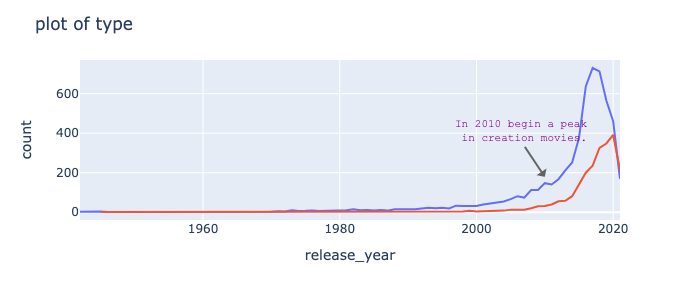

In [9]:
columns = ['country', 'type']
for i in columns:
    plot_year(i)

#### Dual axis

In [10]:
grouped = years.groupby('release_year').agg({'country': 'count'}).reset_index()
# create cummulative sum and prec
grouped['cumsum'] = grouped.country.cumsum()
grouped['cum_percent'] = round(100*grouped['cumsum']/grouped['country'].sum(), 2)

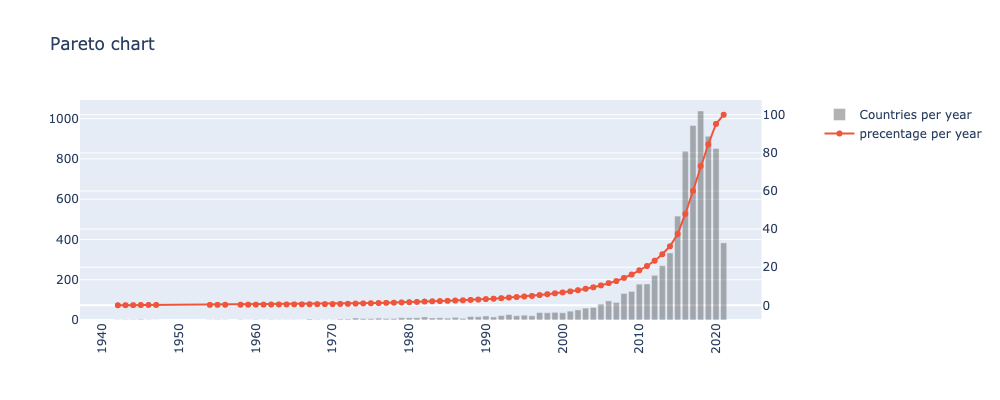

In [11]:
trace1 = go.Bar(
   x=grouped['release_year'],
   y=grouped['country'],
   name='Countries per year',
   marker=dict(color='black'),
    opacity=0.3
)
 
trace2 = go.Scatter(
   x=grouped['release_year'],
   y=grouped['cum_percent'],
   name='precentage per year',
   yaxis='y2',
#    text=grouped['cum_percent'],
#    textposition = 'top center',
#    text_font = dict(color='#E58606'),
   mode='lines+markers'
)
 
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2, secondary_y=True)
# fig.add_trace(trace3, secondary_y=True)
fig['layout'].update(height=400, width = 1000, title = 'Pareto chart', xaxis=dict(tickangle=-90), 
                     hovermode = 'x unified')
# fig.show() -> to display the full interactive plot
fig.show("png") # -> to display the plot in github 

***
### EDA for actors

As we mentioned earlier, now we would like to check who was the busiest actor in each year.
For that, we will need to split each cast to different rows.

In [12]:
df1.head(1)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable."


In [13]:
actors = df1.copy()

In [14]:
actors = actors.drop('cast', axis=1).join(actors['cast'].str.split(',', expand=True).
                                          stack().reset_index(level=1, drop=True).rename('actor'))
actors = actors.dropna(subset=['actor'])
# actors.info()

Now that there we removed nulls, lets check top 10 actors, and then stack top actors per year.

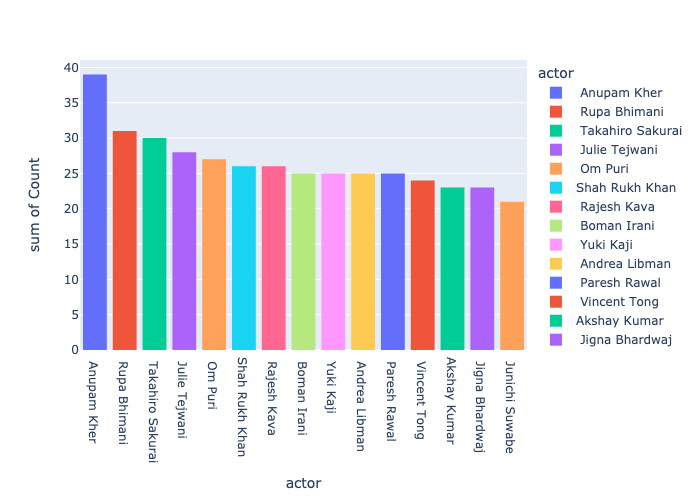

In [18]:
top_15 = actors.groupby('actor').title.count().reset_index().rename(columns={'title': 'Count'})
top_15 = top_15.sort_values(by='Count', ascending=False)
fig = px.histogram(data_frame=top_15[:15], x = 'actor', y = 'Count', color='actor')
# fig.show() -> to display the full interactive plot
fig.show("png") # -> to display the plot in github 


***
#### Check each how many roles the busiest actor had for specific year

In [16]:
act_group = actors.groupby(['release_year', 'actor']).agg({'title': 'count'}).reset_index().rename(
    columns={"title":"count"})

In this type of analysis, I would have also check distribuation of boxplots, but the data in number of count per actor, is not high and change.

**Please note that there are duplicated values that can not present in the graph**

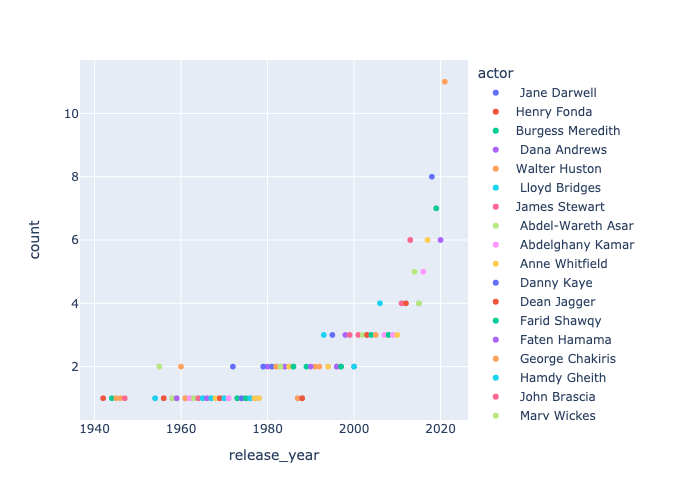

In [19]:
m = act_group.groupby('release_year')['count'].transform('max') == act_group['count']
dfmax = act_group.loc[m]
fig = px.scatter(data_frame=act_group.loc[m], x = 'release_year',y='count', color='actor')
# fig.show() -> to display the full interactive plot
fig.show("png") # -> to display the plot in github 